# K-Means Clustering – Theory

---

## 1. Definition
K-Means is an **unsupervised machine learning algorithm** used for **clustering**.  
It groups data points into **K clusters** based on feature similarity, where each cluster has a **centroid** representing its center.

---

## 2. Key Idea
- The algorithm tries to **minimize the distance** between points and their cluster centroid.  
- Steps of K-Means:
  1. Initialize **K centroids** randomly.  
  2. Assign each data point to the **nearest centroid**.  
  3. Recalculate centroids as the **mean of points** in each cluster.  
  4. Repeat steps 2–3 until **convergence** (no changes in assignments or centroids).

---

## 3. Applications
- Customer segmentation  
- Market basket analysis  
- Image compression  
- Anomaly detection  

---

## 4. Advantages
- Simple and easy to implement.  
- Works well on **large datasets**.  
- Efficient in grouping similar data points.  

---

## 5. Limitations
- Need to **specify K** (number of clusters) in advance.  
- Sensitive to **initial centroid placement**.  
- Assumes **spherical clusters**; not ideal for irregular shapes.  
- Sensitive to **outliers**.  

---

## 6. Model Training
- Available in `scikit-learn` via `KMeans`.  
- Key parameters:
  - `n_clusters`: Number of clusters (K)  
  - `init`: Initialization method (e.g., `'k-means++'`)  
  - `max_iter`: Maximum iterations to converge  
  - `random_state`: For reproducibility  
- After fitting, you can get:
  - `labels_`: Cluster assignment for each data point  
  - `cluster_centers_`: Coordinates of centroids


/tmp/ipython-input-1109570282.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data['Feature1'], data['Feature2'], s=50, cmap='viridis')


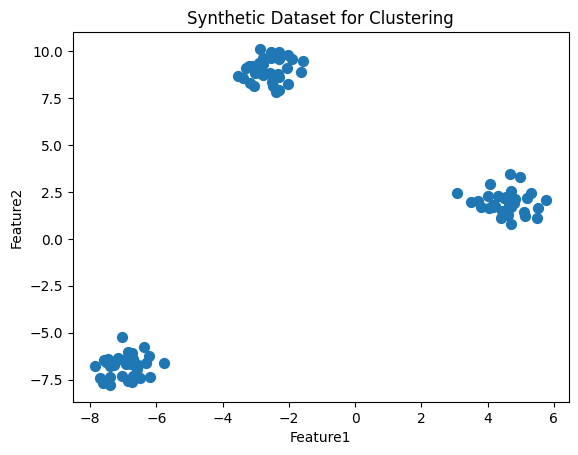

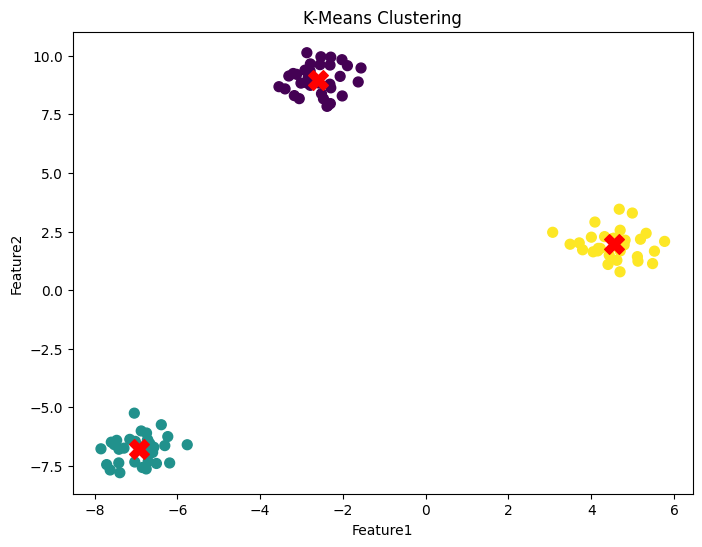

Cluster Centroids:
 [[-2.6043614   8.96717087]
 [-6.92287665 -6.75777385]
 [ 4.55565754  1.95261995]]


In [1]:
# ==============================
# K-Means Clustering
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# 1. Create a synthetic dataset with 2 features and 3 clusters
X, y_true = make_blobs(n_samples=100, centers=3, cluster_std=0.60, random_state=42)
data = pd.DataFrame(X, columns=['Feature1', 'Feature2'])

# 2. Visualize the dataset
plt.scatter(data['Feature1'], data['Feature2'], s=50, cmap='viridis')
plt.title("Synthetic Dataset for Clustering")
plt.xlabel("Feature1")
plt.ylabel("Feature2")
plt.show()

# 3. Initialize KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=100, random_state=42)

# 4. Fit KMeans to the dataset
kmeans.fit(data)

# 5. Get cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# 6. Add cluster labels to the DataFrame
data['Cluster'] = labels

# 7. Visualize the clusters
plt.figure(figsize=(8,6))
plt.scatter(data['Feature1'], data['Feature2'], c=data['Cluster'], s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X')  # centroids
plt.title("K-Means Clustering")
plt.xlabel("Feature1")
plt.ylabel("Feature2")
plt.show()

# 8. Print cluster centers
print("Cluster Centroids:\n", centroids)


# K means Clustering with Kaggle Dataset


In [3]:

from google.colab import files
files.upload()   # Upload your kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username": "kartikrajeshpatel", "key": "KGAT_cff0f44a4e8dc729f2917251ea90ee0f"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d hellbuoy/online-retail-customer-clustering
!unzip -o online-retail-customer-clustering.zip


Dataset URL: https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering
License(s): unknown
  0% 0.00/7.22M [00:00<?, ?B/s]
100% 7.22M/7.22M [00:00<00:00, 928MB/s]
Archive:  online-retail-customer-clustering.zip
  inflating: OnlineRetail.csv        


In [5]:
import pandas as pd

df = pd.read_csv("OnlineRetail.csv", encoding="ISO-8859-1")

print("Rows, Columns:", df.shape)
df.head()
df.info()


Rows, Columns: (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
import datetime as dt
import pandas as pd

# 1️⃣ Remove rows without CustomerID
df = df.dropna(subset=['CustomerID'])

# 2️⃣ Robust datetime parsing (EU format + mixed)
df['InvoiceDate'] = pd.to_datetime(
    df['InvoiceDate'],
    errors='coerce',
    dayfirst=True
)

# Drop rows where date could not be parsed
df = df.dropna(subset=['InvoiceDate'])

# 3️⃣ Remove cancelled transactions (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# 4️⃣ Remove negative or zero quantities & prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# 5️⃣ Create TotalAmount (CORRECT monetary value)
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# 6️⃣ Snapshot date (last transaction + 1 day)
snapshot = df['InvoiceDate'].max() + dt.timedelta(days=1)

# 7️⃣ RFM Aggregation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                               # Frequency
    'TotalAmount': 'sum'                                  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(
    rfm[['Recency', 'Frequency', 'Monetary']]
)


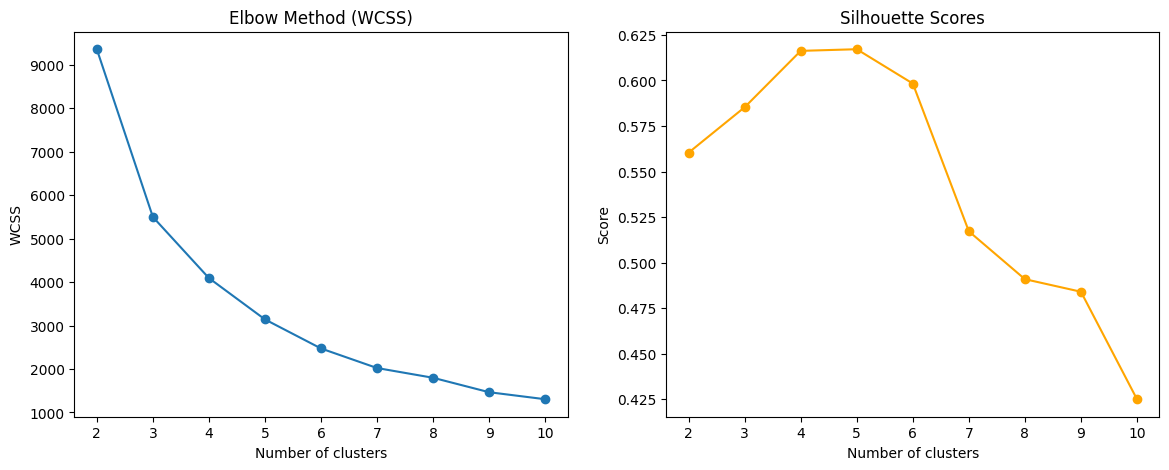

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss = []
sil_scores = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = km.fit_predict(rfm_scaled)
    wcss.append(km.inertia_)
    sil_scores.append(silhouette_score(rfm_scaled, labels))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(14,5))

# Elbow
ax[0].plot(range(2,11), wcss, '-o')
ax[0].set_title("Elbow Method (WCSS)")
ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("WCSS")

# Silhouette
ax[1].plot(range(2,11), sil_scores, '-o', color='orange')
ax[1].set_title("Silhouette Scores")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("Score")

plt.show()


In [9]:
k = 5
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


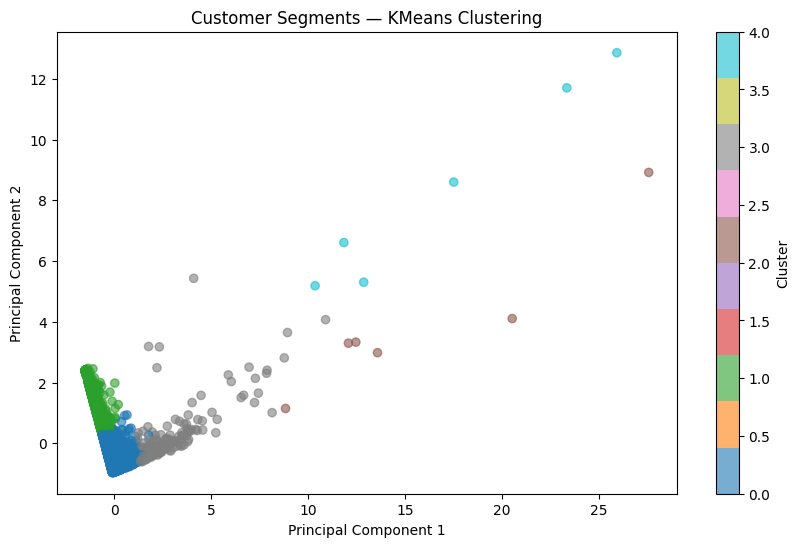

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(10,6))
plt.scatter(components[:,0], components[:,1],
            c=rfm['Cluster'], cmap='tab10', alpha=0.6)

plt.title("Customer Segments — KMeans Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [11]:
cluster_summary = rfm.groupby('Cluster').mean().round(2)
cluster_summary


,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,15290.41,43.81,3.69,1358.77
1,15346.23,248.47,1.55,480.42
2,14751.00,1.50,135.83,58381.12
3,15220.39,15.72,22.30,13534.00
4,15535.83,7.67,42.83,190863.46


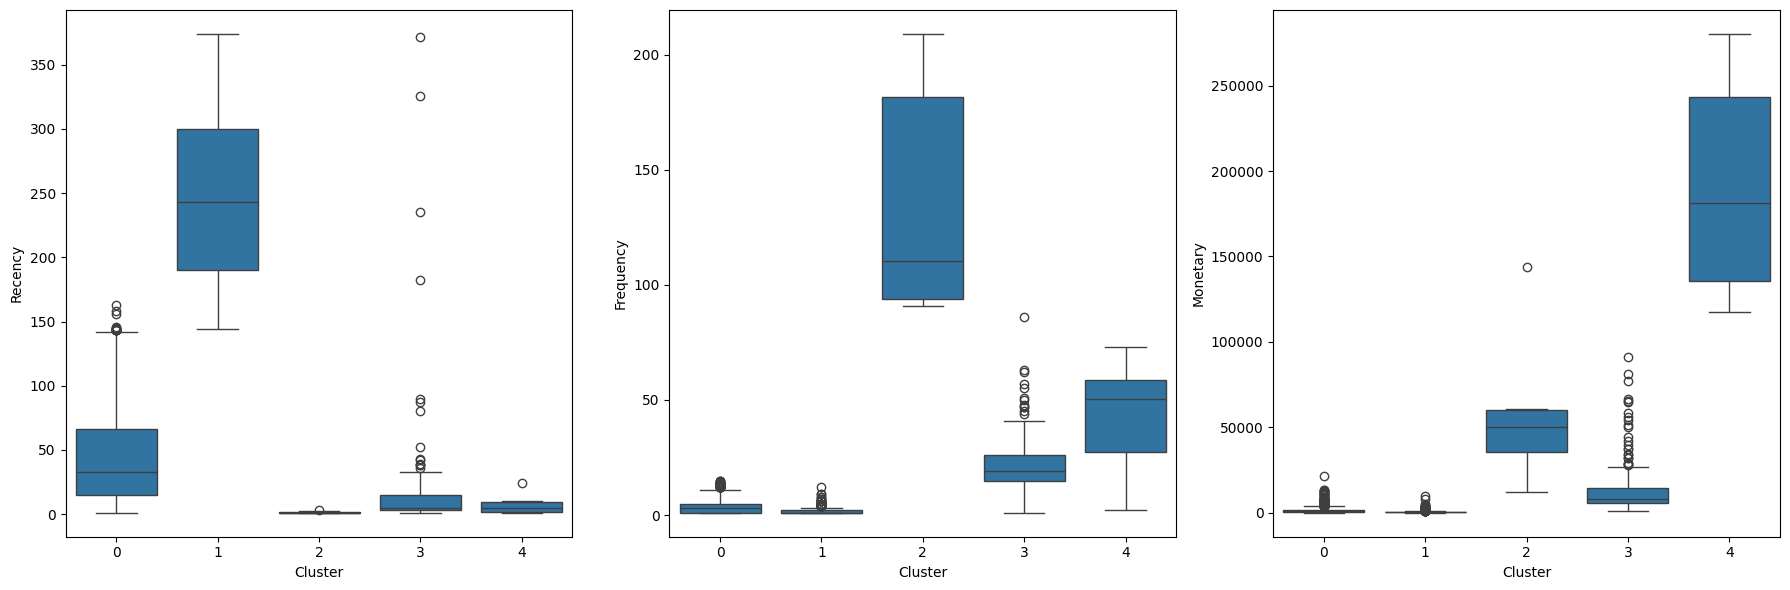

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correct RFM features
features = ['Recency', 'Frequency', 'Monetary']

fig, axs = plt.subplots(1, 3, figsize=(18,6))

for i, f in enumerate(features):
    sns.boxplot(x='Cluster', y=f, data=rfm, ax=axs[i])

plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

cluster_summary = (
    rfm.groupby('Cluster')[['Recency','Frequency','Monetary']]
       .mean()
)

cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,43.808170,3.686928,1358.774086
1,248.469426,1.553151,480.423604
2,1.500000,135.833333,58381.123333
3,15.724138,22.300493,13533.997044
4,7.666667,42.833333,190863.461667


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cluster_summary_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_summary),
    index=cluster_summary.index,
    columns=cluster_summary.columns
)

cluster_summary_scaled


,Recency,Frequency,Monetary
Cluster,,,
0,0.171309,0.015890,0.004614
1,1.000000,0.000000,0.000000
2,0.000000,1.000000,0.304127
3,0.057595,0.154508,0.068565
4,0.024969,0.307418,1.000000


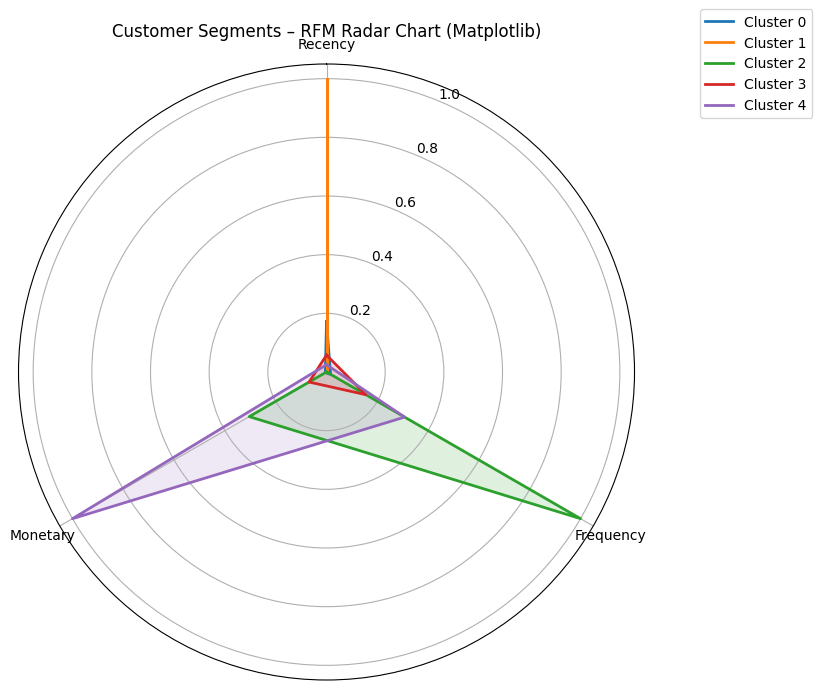

In [15]:
import numpy as np
import matplotlib.pyplot as plt

labels = cluster_summary_scaled.columns.tolist()
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]   # close the loop

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

for cluster in cluster_summary_scaled.index:
    values = cluster_summary_scaled.loc[cluster].tolist()
    values += values[:1]

    ax.plot(angles, values, linewidth=2, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.15)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Customer Segments – RFM Radar Chart (Matplotlib)", pad=20)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Use RFM features
features = rfm[['Recency','Frequency','Monetary']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Fit K-Means
k = 5  # or whatever optimal k you chose
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)


In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X_scaled)

rfm['PCA1'] = components[:,0]
rfm['PCA2'] = components[:,1]


/tmp/ipython-input-2187193869.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', k)


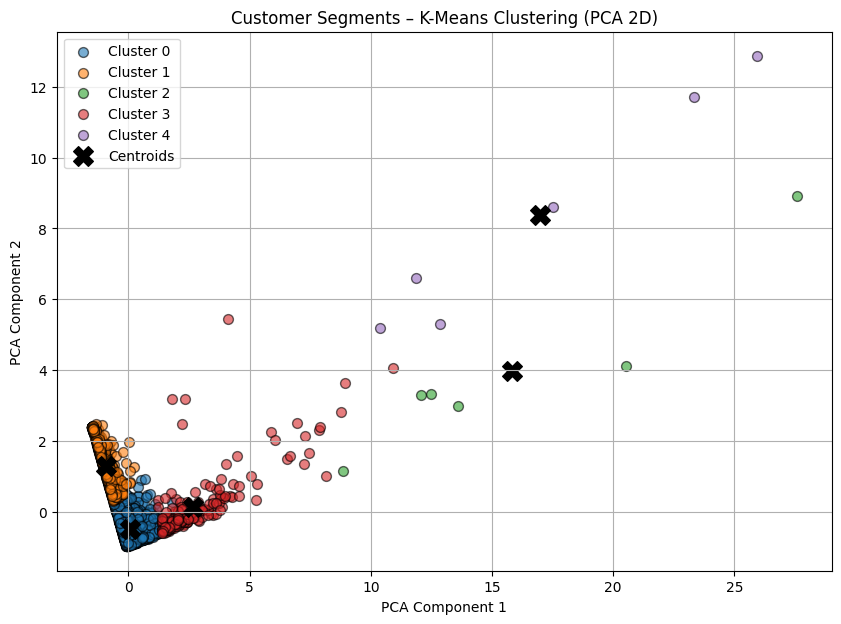

In [18]:
plt.figure(figsize=(10,7))
colors = plt.cm.get_cmap('tab10', k)

for cluster in range(k):
    subset = rfm[rfm['Cluster'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'],
                label=f'Cluster {cluster}',
                alpha=0.6,
                s=50,
                edgecolor='k')

# Plot centroids
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:,0], centroids[:,1],
            c='black', s=200, marker='X', label='Centroids')

plt.title("Customer Segments – K-Means Clustering (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()
